# Churn Prediction Modeling Workflow

This notebook walks through an end‑to‑end workflow for building and comparing machine‑learning models that predict customer churn. We start with simple baselines and progressively add sophistication – including feature engineering, class balancing, and ensemble methods. Each step is explained in plain language so that readers with basic Python and data‑science knowledge can follow along.

## 1 Setup and Library Imports

In [10]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "8"  # Set to the number of CPU cores you want to use for parallel processing 

# Scikit‑learn core
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, precision_recall_curve, roc_curve,
                             average_precision_score, accuracy_score, f1_score)

# Basic models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Ensemble models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, BaggingClassifier

# Imbalance handling
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Advanced gradient boosting (requires xgboost)
try:
    from xgboost import XGBClassifier
    has_xgb = True
except ImportError:
    has_xgb = False
    print("xgboost not installed – skipping XGBClassifier. !pip install xgboost to enable.")

RANDOM_STATE = 42
%matplotlib inline


## 2 Load the Data

Replace `DATA_PATH` with the actual dataset path when you are ready to run on the full data. For demonstration, we fall back to the uploaded sample if the full dataset is not found.

In [3]:

from pathlib import Path

#SAMPLE_PATH = Path('/mnt/data/SAMPLE_merged_cleaned_churn_dataset.csv')
#FULL_PATH = Path('/mnt/data/DATA_merged_cleaned_churn_dataset.csv')
SAMPLE_PATH = Path('SAMPLE_merged_cleaned_churn_dataset.csv')
FULL_PATH = Path('DATA_merged_cleaned_churn_dataset.csv')

DATA_PATH = FULL_PATH if FULL_PATH.exists() else SAMPLE_PATH

df = pd.read_csv(DATA_PATH)
print(f"Loaded {df.shape[0]:,} rows and {df.shape[1]} columns from {DATA_PATH.name}")
df.head()


Loaded 9,623 rows and 76 columns from DATA_merged_cleaned_churn_dataset.csv


,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,...,price_peak_var_dif,price_peak_var_perc,price_mid_peak_var_dif,price_mid_peak_var_perc,price_off_peak_fix_dif,price_off_peak_fix_perc,price_peak_fix_dif,price_peak_fix_perc,price_mid_peak_fix_dif,price_mid_peak_fix_perc
0,0.000713,0.0,0.000682,0.590612,0.077689,0.525172,0.656448,0.005377,0.002999,0.0,...,0.028890,0.024290,0.000546,0.001379,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0
1,0.001337,0.0,0.002591,0.758771,0.629482,0.980852,0.948203,0.009613,0.011393,0.0,...,0.029299,0.029609,0.000000,0.000000,2.699984e-08,5.985984e-08,0.0,0.0,0.0,0.0
2,0.004761,0.0,0.001634,0.614324,0.167331,0.546256,0.702960,0.010431,0.004282,0.0,...,0.028890,0.024576,0.000546,0.001364,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0
3,0.004199,0.0,0.002837,0.617469,0.193227,0.940835,0.716702,0.033028,0.012476,0.0,...,0.030990,0.026210,0.000546,0.001354,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0
4,0.001745,0.0,0.004035,0.722236,0.328685,0.642212,0.788584,0.014530,0.017745,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0


### 2.1 Quick Exploratory Analysis

In [18]:

#df.info()
pd.set_option('display.max_columns', None)
display(df.describe(include='all').transpose())

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
cons_12m,9623.0,NaN,NaN,NaN,0.037816,0.111863,0.0,0.001348,0.003521,0.011167,1.0
cons_gas_12m,9623.0,NaN,NaN,NaN,0.00963,0.047637,0.0,0.0,0.0,0.0,1.0
cons_last_month,9623.0,NaN,NaN,NaN,0.031668,0.101146,0.000001,0.001065,0.002868,0.008146,1.0
date_activ,9623.0,NaN,NaN,NaN,0.681404,0.149957,0.0,0.593032,0.693927,0.793612,1.0
date_end,9623.0,NaN,NaN,NaN,0.351597,0.213365,0.0,0.169323,0.344622,0.539841,0.996016
date_modif_prod,9623.0,NaN,NaN,NaN,0.756835,0.199616,0.0,0.57315,0.797332,0.946213,1.0
date_renewal,9623.0,NaN,NaN,NaN,0.793505,0.123813,0.0,0.693446,0.788584,0.897463,1.0
forecast_cons_12m,9623.0,NaN,NaN,NaN,0.026462,0.032291,0.0,0.007221,0.016545,0.035769,1.0
forecast_cons_year,9623.0,NaN,NaN,NaN,0.012115,0.021691,0.0,0.00191,0.006398,0.015547,1.0
forecast_discount_energy,9623.0,NaN,NaN,NaN,0.032547,0.170561,0.0,0.0,0.0,0.0,1.0


### 2.2 Target Variable Distribution

Class imbalance can seriously affect model performance. We will visualise the proportion of churned versus non‑churned customers.

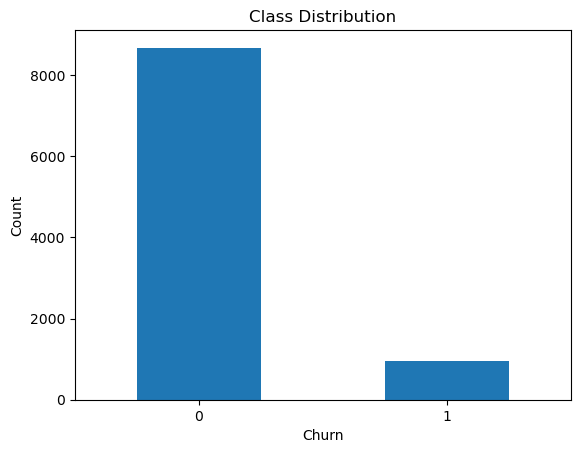

Minority / majority ratio: 0.109


In [6]:

target_col = 'churn'  # adjust if your target has a different name
class_counts = df[target_col].value_counts().sort_index()
ax = class_counts.plot(kind='bar', rot=0)
ax.set_xlabel('Churn')
ax.set_ylabel('Count')
ax.set_title('Class Distribution')
plt.show()

imbalance_ratio = class_counts.min() / class_counts.max()
print(f"Minority / majority ratio: {imbalance_ratio:.3f}")


## 3 Train‑Test Split & Pre‑processing Pipeline

We will keep **20 percent** of the data as an unseen test set. For preprocessing we:

1. Identify numerical and categorical columns.
2. Scale numerical features with *StandardScaler*.
3. One‑hot encode categorical features (dropping one level to avoid multicollinearity).

In [23]:

y = df[target_col]
X = df.drop(columns=[target_col])

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(exclude=['int64', 'float64']).columns.tolist()

numeric_pipeline = Pipeline([('scaler', StandardScaler())])
#categorical_pipeline = Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore', sparse=True))])
categorical_pipeline = Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_features),
        ('cat', categorical_pipeline, categorical_features)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)
print(f"Train size: {X_train.shape[0]:,}; Test size: {X_test.shape[0]:,}")

# Output the schema of the features
print("\nFeature schema after split:")
pd.set_option('display.max_rows', None)  # Show all rows without truncation
pd.set_option('display.max_columns', None)  # Show all columns without truncation
#display(pd.DataFrame({
#    "Column": X.columns,
#    "Type": [X[col].dtype for col in X.columns]
#}))
display(X.describe(include='all').transpose())

Train size: 7,698; Test size: 1,925

Feature schema after split:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
cons_12m,9623.0,NaN,NaN,NaN,0.037816,0.111863,0.0,0.001348,0.003521,0.011167,1.0
cons_gas_12m,9623.0,NaN,NaN,NaN,0.00963,0.047637,0.0,0.0,0.0,0.0,1.0
cons_last_month,9623.0,NaN,NaN,NaN,0.031668,0.101146,0.000001,0.001065,0.002868,0.008146,1.0
date_activ,9623.0,NaN,NaN,NaN,0.681404,0.149957,0.0,0.593032,0.693927,0.793612,1.0
date_end,9623.0,NaN,NaN,NaN,0.351597,0.213365,0.0,0.169323,0.344622,0.539841,0.996016
date_modif_prod,9623.0,NaN,NaN,NaN,0.756835,0.199616,0.0,0.57315,0.797332,0.946213,1.0
date_renewal,9623.0,NaN,NaN,NaN,0.793505,0.123813,0.0,0.693446,0.788584,0.897463,1.0
forecast_cons_12m,9623.0,NaN,NaN,NaN,0.026462,0.032291,0.0,0.007221,0.016545,0.035769,1.0
forecast_cons_year,9623.0,NaN,NaN,NaN,0.012115,0.021691,0.0,0.00191,0.006398,0.015547,1.0
forecast_discount_energy,9623.0,NaN,NaN,NaN,0.032547,0.170561,0.0,0.0,0.0,0.0,1.0


## 4 Utility Functions

In [8]:

def evaluate_model(name, pipeline, X_test, y_test, results):
    """Fit, predict, and store evaluation metrics."""
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1] if hasattr(pipeline, 'predict_proba') else None

    metrics = {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': None,
        'Recall': None,
        'F1': f1_score(y_test, y_pred),
        'ROC_AUC': None,
        'PR_AUC': None
    }

    try:
        metrics['Precision'] = classification_report(
            y_test, y_pred, output_dict=True, zero_division=0)['1']['precision']
        metrics['Recall'] = classification_report(
            y_test, y_pred, output_dict=True, zero_division=0)['1']['recall']
    except KeyError:
        pass

    if y_prob is not None:
        metrics['ROC_AUC'] = roc_auc_score(y_test, y_prob)
        pr, rc, _ = precision_recall_curve(y_test, y_prob)
        metrics['PR_AUC'] = average_precision_score(y_test, y_prob)

    results.append(metrics)

def plot_curves(pipelines, X_test, y_test, title_suffix=''):
    """Plot ROC and PR curves for multiple pipelines."""
    plt.figure(figsize=(6,5))
    for name, pl in pipelines.items():
        if hasattr(pl, 'predict_proba'):
            y_prob = pl.predict_proba(X_test)[:,1]
            fpr, tpr, _ = roc_curve(y_test, y_prob)
            plt.plot(fpr, tpr, label=name)
    plt.plot([0,1], [0,1], linestyle='--', alpha=0.6)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves ' + title_suffix)
    plt.legend()
    plt.show()

    plt.figure(figsize=(6,5))
    for name, pl in pipelines.items():
        if hasattr(pl, 'predict_proba'):
            y_prob = pl.predict_proba(X_test)[:,1]
            pr, rc, _ = precision_recall_curve(y_test, y_prob)
            plt.plot(rc, pr, label=name)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision‑Recall Curves ' + title_suffix)
    plt.legend()
    plt.show()


## 5 Baseline Models

Our first benchmark includes:

* **DummyClassifier** – always predicts the majority class.
* **Logistic Regression** – a simple linear model.
* **k‑Nearest Neighbors (kNN)**.
* **Decision Tree**.

These baselines give us a yardstick for judging more advanced techniques.

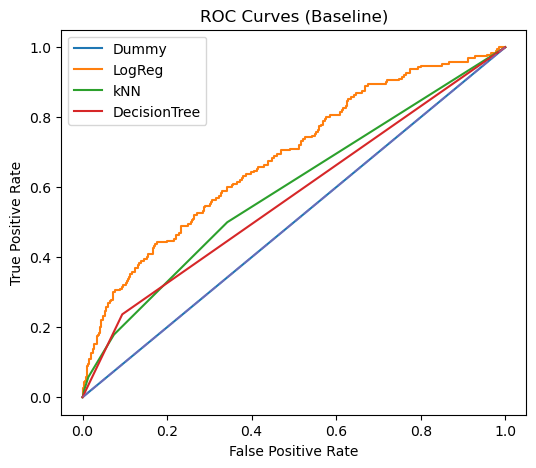

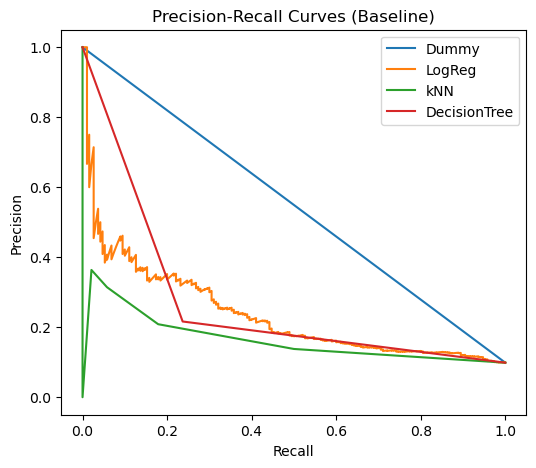

,Accuracy,Precision,Recall,F1,ROC_AUC,PR_AUC
Model,,,,,,
Dummy,0.901,0.000,0.000,0.000,0.500,0.099
LogReg,0.902,1.000,0.011,0.021,0.685,0.239
kNN,0.895,0.314,0.058,0.098,0.592,0.138
DecisionTree,0.840,0.216,0.237,0.226,0.571,0.127


In [11]:

baseline_models = {
    'Dummy': DummyClassifier(strategy='most_frequent', random_state=RANDOM_STATE),
    'LogReg': LogisticRegression(max_iter=1000, class_weight=None, random_state=RANDOM_STATE),
    'kNN': KNeighborsClassifier(n_neighbors=5),
    'DecisionTree': DecisionTreeClassifier(random_state=RANDOM_STATE)
}

baseline_pipes = {name: Pipeline([('pre', preprocess), ('clf', model)])
                  for name, model in baseline_models.items()}

results = []
for name, pipe in baseline_pipes.items():
    pipe.fit(X_train, y_train)
    evaluate_model(name, pipe, X_test, y_test, results)

plot_curves(baseline_pipes, X_test, y_test, '(Baseline)')
baseline_results = pd.DataFrame(results).set_index('Model').round(3)
display(baseline_results)


## 6 Addressing Class Imbalance

The churn classes are imbalanced. We will apply **SMOTE** (Synthetic Minority Over‑sampling Technique) within the pipeline to generate synthetic minority examples. We compare performance with the unbalanced counterparts.

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packag

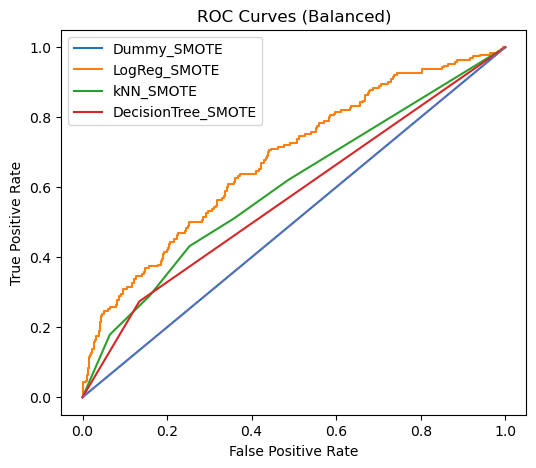

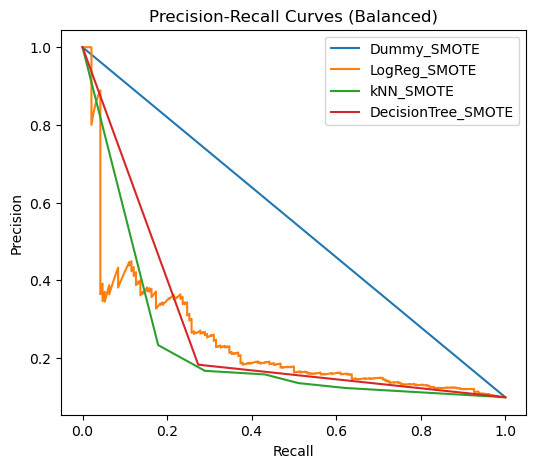

In [18]:

balanced_models = {name + '_SMOTE': model for name, model in baseline_models.items()}

balanced_pipes = {
    name: ImbPipeline([
        ('pre', preprocess),
        ('smote', SMOTE(random_state=RANDOM_STATE)),
        ('clf', model)
    ])
    for name, model in balanced_models.items()
}

for name, pipe in balanced_pipes.items():
    pipe.fit(X_train, y_train)
    evaluate_model(name, pipe, X_test, y_test, results)

plot_curves(balanced_pipes, X_test, y_test, '(Balanced)')


## 7 Feature Engineering & Correlation Pruning

Highly correlated numerical features can hurt some models and increase complexity without adding information. We:

1. Compute the Pearson correlation matrix on numeric columns.
2. Drop one feature from any pair with absolute correlation above **0.9**.

Feel free to adjust the threshold.

In [20]:

corr_matrix = df[numeric_features].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
print(f"Dropping {len(to_drop)} highly correlated features:", to_drop[:15])

X_reduced = X.drop(columns=to_drop)

numeric_features_reduced = [col for col in numeric_features if col not in to_drop]

preprocess_reduced = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features_reduced),
        #('cat', OneHotEncoder(handle_unknown='ignore', sparse=True), categorical_features)
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)


Dropping 33 highly correlated features: ['cons_last_month', 'imp_cons', 'margin_net_pow_ele', 'num_years_antig', 'price_off_peak_var_mean', 'price_off_peak_var_min', 'price_off_peak_var_max', 'price_off_peak_var_last', 'price_peak_var_mean', 'price_peak_var_min', 'price_peak_var_max', 'price_peak_var_last', 'price_mid_peak_var_min', 'price_mid_peak_var_max', 'price_mid_peak_var_last']


## 8 Advanced Single Models (Bagging & Boosting)

We now train more powerful learners:

* **Random Forest** (bagging)
* **Gradient Boosting** (`GradientBoostingClassifier`)
* **XGBoost** (if available)

All are wrapped in a balanced SMOTE pipeline and use the reduced feature set.

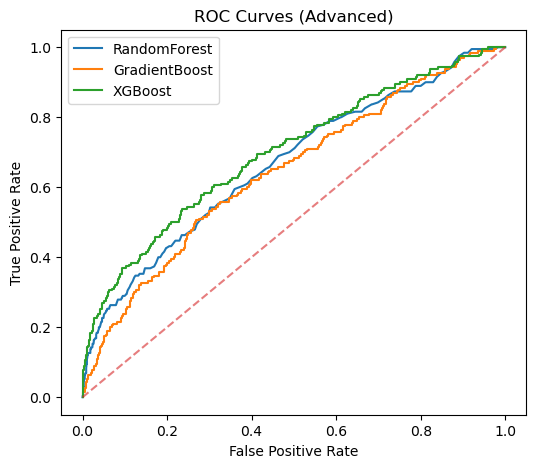

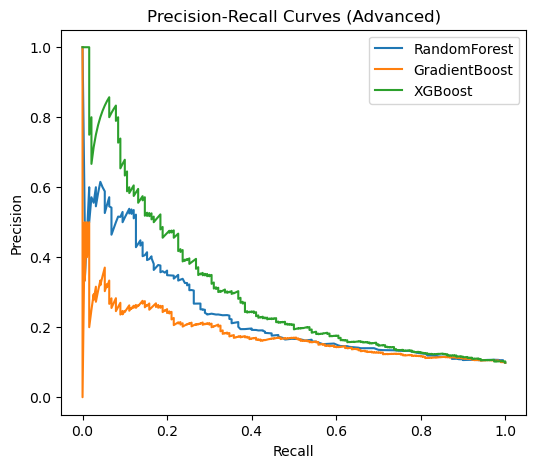

In [21]:

advanced_models = {
    'RandomForest': RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=RANDOM_STATE),
    'GradientBoost': GradientBoostingClassifier(random_state=RANDOM_STATE),
}

if has_xgb:
    advanced_models['XGBoost'] = XGBClassifier(
        objective='binary:logistic', eval_metric='logloss',
        n_estimators=500, learning_rate=0.05, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, random_state=RANDOM_STATE
    )

advanced_pipes = {
    name: ImbPipeline([
        ('pre', preprocess_reduced),
        ('smote', SMOTE(random_state=RANDOM_STATE)),
        ('clf', model)
    ])
    for name, model in advanced_models.items()
}

for name, pipe in advanced_pipes.items():
    pipe.fit(X_train, y_train)
    evaluate_model(name, pipe, X_test, y_test, results)

plot_curves(advanced_pipes, X_test, y_test, '(Advanced)')


## 9 Ensemble of Top Performers

Finally, we build a **soft‑voting ensemble** using the three models with the highest F1 score so far (based on the growing `results` list).

In [22]:

results_df = pd.DataFrame(results)
top_models = results_df.sort_values('F1', ascending=False).head(3)['Model'].tolist()
print('Top candidates:', top_models)

ensemble_estimators = []
for model_name in top_models:
    # Retrieve the already fitted pipeline by name
    if model_name in baseline_pipes:
        ensemble_estimators.append((model_name, baseline_pipes[model_name]))
    elif model_name in balanced_pipes:
        ensemble_estimators.append((model_name, balanced_pipes[model_name]))
    elif model_name in advanced_pipes:
        ensemble_estimators.append((model_name, advanced_pipes[model_name]))
    else:
        print("Warning – model not found:", model_name)

ensemble_clf = VotingClassifier(
    estimators=ensemble_estimators,
    voting='soft'
)

ensemble_pipe = ensemble_clf  # Already contains preprocess inside each estimator
ensemble_pipe.fit(X_train, y_train)
evaluate_model('VotingEnsemble', ensemble_pipe, X_test, y_test, results)


Top candidates: ['XGBoost', 'LogReg_SMOTE', 'kNN_SMOTE']


## 10 Performance Comparison Table

In [23]:

final_results = (pd.DataFrame(results)
                 .drop_duplicates('Model', keep='last')
                 .set_index('Model')
                 .sort_values('F1', ascending=False))
display(final_results.round(3))


,Accuracy,Precision,Recall,F1,ROC_AUC,PR_AUC
Model,,,,,,
VotingEnsemble,0.832,0.243,0.332,0.281,0.681,0.284
XGBoost,0.898,0.462,0.189,0.269,0.698,0.300
LogReg_SMOTE,0.609,0.150,0.637,0.243,0.678,0.240
kNN_SMOTE,0.716,0.157,0.432,0.231,0.600,0.144
DecisionTree,0.840,0.216,0.237,0.226,0.571,0.127
RandomForest,0.895,0.414,0.153,0.223,0.666,0.234
GradientBoost,0.836,0.209,0.237,0.222,0.644,0.179
DecisionTree_SMOTE,0.807,0.182,0.274,0.219,0.570,0.122
kNN,0.895,0.314,0.058,0.098,0.592,0.138


### 10.1 Visual Comparison

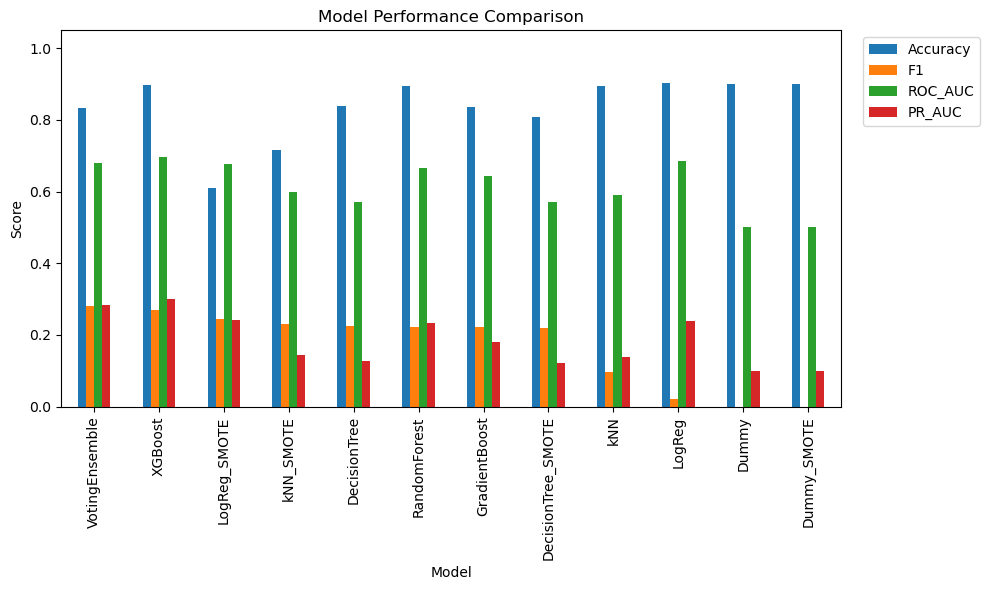

In [24]:

final_results[['Accuracy', 'F1', 'ROC_AUC', 'PR_AUC']].plot.bar(figsize=(10,6))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.ylim(0,1.05)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()



## 11 Key Takeaways

* **Baseline models** establish a reference – anything better than a *DummyClassifier* is progress.
* **Balancing the training set** with SMOTE typically boosts *recall* for the minority class, sometimes at the cost of precision. Always compare metrics that reflect your business needs (e.g., F1 or PR‑AUC for rare‑event detection).
* **Tree‑based ensembles** (Random Forest, Gradient/Extreme Boosting) often outperform linear baselines on tabular data once categorical encoding and scaling are in place.
* **Feature pruning** removes redundant signals, reduces training time, and can improve generalisation.
* **Voting/stacking ensembles** can squeeze out extra performance by leveraging model diversity – but only if the individual learners make different errors.
* **Next steps** might include hyper‑parameter tuning with `GridSearchCV`/`Optuna`, testing other balancing methods (e.g., *NearMiss*, *ADASYN*), or trying automated machine‑learning frameworks.
